In [25]:
import cdsapi
import xarray as xr
import pandas as pd
import numpy as np
import os, zipfile
from entsoe import EntsoePandasClient
import matplotlib.pyplot as plt, pandas as pd
import statsmodels.formula.api as smf
from dataclasses import dataclass
import cvxpy as cp
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv 
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
import torch, torch.nn as nn, torch.optim as optim
from copy import deepcopy
from sklearn.multioutput import MultiOutputRegressor  
from cvxpylayers.torch import CvxpyLayer 

In [2]:
# Load in other notebook
df_merged = pd.read_csv("merged_dataset_7month.csv")

In [3]:
# ────────────────────────────────────────────────────────────────────────
# Fix-0 · ensure df_merged is indexed by a timezone-aware DatetimeIndex
# ────────────────────────────────────────────────────────────────────────
if "utc" not in df_merged.columns:
    raise KeyError("Expected a 'utc' column with timestamps.")

# convert to pandas datetime (keeps existing UTC offset if any)
df_merged["utc"] = pd.to_datetime(df_merged["utc"], utc=True)

# set as index and sort (optional but tidy)
df_merged = df_merged.set_index("utc").sort_index()

print("Index dtype:", df_merged.index.dtype, "   rows:", len(df_merged))

Index dtype: datetime64[ns, UTC]    rows: 4343


In [4]:
df_merged.head()

,solar_MW,wind_MW,hydro_MW,price_EUR_MWh,u10_mps,v10_mps,temperature_C,solar_Wm2,wind_speed_mps
utc,,,,,,,,,
2018-12-31 23:00:00+00:00,0.0,670.00,0.0,68.92,4.050956,1.354894,7.214386,408.5206,4.271532
2019-01-01 00:00:00+00:00,0.0,693.00,0.0,64.98,4.300705,1.285044,7.137695,0.0000,4.488585
2019-01-01 01:00:00+00:00,0.0,734.75,0.0,60.27,4.548635,1.055783,7.108643,0.0000,4.669557
2019-01-01 02:00:00+00:00,0.0,778.00,0.0,49.97,4.759119,0.806365,7.050262,0.0000,4.826949
2019-01-01 03:00:00+00:00,0.0,804.50,0.0,47.66,4.916848,0.561395,7.027405,0.0000,4.948794


In [5]:
# ══════════════════════════════════════════════════════════════════════
#  Cell S — Reproducibility seed (run once before any ML / solver code)
# ══════════════════════════════════════════════════════════════════════
import os, random, numpy as np, torch

SEED = 42  # choose any integer

def set_seed(seed: int = 42) -> None:
    """Set all relevant PRNG seeds for full reproducibility."""
    os.environ["PYTHONHASHSEED"] = str(seed)          # built-ins & hashing
    random.seed(seed)                                 # Python random
    np.random.seed(seed)                              # NumPy
    torch.manual_seed(seed)                           # PyTorch CPU
    torch.cuda.manual_seed_all(seed)                  # PyTorch GPU(s)
    torch.backends.cudnn.deterministic = True         # ensure determinism
    torch.backends.cudnn.benchmark     = False        # disable autotune

set_seed(SEED)


In [28]:
# ── Battery parameters ────────────────────────────────────────────────
@dataclass
class BatteryParams:
    E_max:    float = 10.0     # MWh
    P_ch_max: float = 5.0      # MW
    P_dis_max:float = 5.0      # MW
    eta_ch:   float = 0.95
    eta_dis:  float = 0.95
    delta_t:  float = 1.0      # h
    soc_init: float = 5.0      # MWh (50 %)

params = BatteryParams()

In [7]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Helpers, price vector, env factories, binning & Q-table bootstrap  ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ----------------------------------------------------------------------
# 1.  Price vectors ── chronological train/test split (85 / 15 %)
# ----------------------------------------------------------------------
price_vec       = df_merged["price_EUR_MWh"].to_numpy(dtype=np.float32)
split_idx       = int(0.85 * len(price_vec))
price_train_vec = price_vec[:split_idx]        # for the LinUCB baseline, etc.

# ----------------------------------------------------------------------
# 2.  Continuous-action environment factory
# ----------------------------------------------------------------------
def make_env(seed: int = SEED):
    env = BatteryArbEnv(price_vec, params)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

# ----------------------------------------------------------------------
# 3.  Discrete-action wrapper & factory (bandits / tabular Q-learning)
# ----------------------------------------------------------------------
class DiscreteActionWrapper(gym.ActionWrapper):
    """Map discrete {0: discharge, 1: idle, 2: charge} → continuous action."""
    def __init__(self, env):
        super().__init__(env)
        self.action_space = spaces.Discrete(3)

    def action(self, act):
        mapping = np.array([-1.0, 0.0, 1.0], dtype=np.float32)
        return np.asarray([mapping[int(act)]], dtype=np.float32)

def make_env_disc(seed: int = SEED):
    env = BatteryArbEnv(price_vec, params)
    env = DiscreteActionWrapper(env)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

# ----------------------------------------------------------------------
# 4.  Binning helpers for the 10 × 10 Q-table
# ----------------------------------------------------------------------
_price_edges = np.linspace(0, 200, 11)           # 0–200 €/MWh → 10 bins
_soc_edges   = np.linspace(0, params.E_max, 11)  # SOC bins

def price_bin(p: float) -> int:
    return int(np.digitize(p, _price_edges) - 1)

def soc_bin(s: float) -> int:
    return int(np.digitize(s, _soc_edges) - 1)

# ----------------------------------------------------------------------
# 5.  Initialise (or load) the Q-table  (shape: price × soc × actions)
# ----------------------------------------------------------------------
Q_PATH = "trained_Q_table.npy"
if os.path.exists(Q_PATH):
    Q = np.load(Q_PATH)
    if Q.shape != (10, 10, 3):                  # shape guard
        Q = np.zeros((10, 10, 3), dtype=np.float32)
else:
    Q = np.zeros((10, 10, 3), dtype=np.float32)


In [102]:
# at top of Cell A
df_merged.drop(columns=[f"price_t+{k}" for k in range(1,25)],
               inplace=True, errors="ignore")


In [103]:
df_merged.columns

Index(['solar_MW', 'wind_MW', 'hydro_MW', 'price_EUR_MWh', 'u10_mps',
       'v10_mps', 'temperature_C', 'solar_Wm2', 'wind_speed_mps', 'hour',
       'day_of_week', 'price_salvage', 'solar_Wm2_lag_1', 'solar_Wm2_lag_2',
       'solar_Wm2_lag_3', 'solar_Wm2_lag_4', 'solar_Wm2_lag_5',
       'solar_Wm2_lag_6', 'solar_Wm2_lag_7', 'solar_Wm2_lag_8',
       'solar_Wm2_lag_9', 'solar_Wm2_lag_10', 'solar_Wm2_lag_11',
       'solar_Wm2_lag_12', 'solar_Wm2_lag_13', 'solar_Wm2_lag_14',
       'solar_Wm2_lag_15', 'solar_Wm2_lag_16', 'solar_Wm2_lag_17',
       'solar_Wm2_lag_18', 'solar_Wm2_lag_19', 'solar_Wm2_lag_20',
       'solar_Wm2_lag_21', 'solar_Wm2_lag_22', 'solar_Wm2_lag_23',
       'solar_Wm2_lag_24', 'wind_speed_mps_lag_1', 'wind_speed_mps_lag_2',
       'wind_speed_mps_lag_3', 'wind_speed_mps_lag_4', 'wind_speed_mps_lag_5',
       'wind_speed_mps_lag_6', 'wind_speed_mps_lag_7', 'wind_speed_mps_lag_8',
       'wind_speed_mps_lag_9', 'wind_speed_mps_lag_10',
       'wind_speed_mps_lag_1

In [104]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell A — Hour-ahead design matrix X_h and target matrix Y_h         ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ── 1.  Feature engineering ────────────────────────────────────────────
lags = range(1, 25)                                    # 24 previous hours

# price lags t-1 … t-24
price_lag_df = pd.concat(
    {f"price_lag_{k}": df_merged["price_EUR_MWh"].shift(k) for k in lags},
    axis=1
)

# calendar & exogenous vars
df_feat = (
    df_merged
    .assign(
        hour        = df_merged.index.hour,
        day_of_week = df_merged.index.dayofweek
    )
    .join(price_lag_df)
)

# targets: prices t+1 … t+24
target_df = pd.concat(
    {f"price_t+{k}": df_merged["price_EUR_MWh"].shift(-k) for k in lags},
    axis=1
)

df_full = df_feat.join(target_df).dropna()

df_merged = df_full        # promote the enriched frame to the global name


feat_cols   = list(price_lag_df.columns) + [
    "solar_MW", "wind_MW", "temperature_C", "hour", "day_of_week"
]
target_cols = list(target_df.columns)

X_h = df_full[feat_cols].to_numpy(np.float32)
Y_h = df_full[target_cols].to_numpy(np.float32)


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell W — Weather feature engineering (second pass)                  ║
# ║        • 24-h lags of key weather cols                               ║
# ║        • 6-h rolling mean & std                                      ║
# ╚══════════════════════════════════════════════════════════════════════╝
import re
from sklearn.preprocessing import StandardScaler

weather_cols = ["solar_Wm2", "wind_speed_mps", "temperature_C"]

# 1.  Add 24-hour lags ONLY for weather columns
for col in weather_cols:
    for k in range(1, 25):
        new_col = f"{col}_lag_{k}"
        if new_col not in df_merged.columns:           # guard duplicates
            df_merged[new_col] = df_merged[col].shift(k)

# 2.  Add centred 6-hour rolling mean & std for weather cols
for col in weather_cols:
    roll_mean = f"{col}_roll6_mean"
    roll_std  = f"{col}_roll6_std"
    if roll_mean not in df_merged.columns:
        df_merged[roll_mean] = df_merged[col].rolling(6, min_periods=3).mean()
    if roll_std not in df_merged.columns:
        df_merged[roll_std]  = df_merged[col].rolling(6, min_periods=3).std()

# 3.  Rebuild feature list (price lags already exist from Cell A)
lag_price_cols   = [f"price_lag_{k}" for k in range(1, 25)]
lag_weather_cols = [c for c in df_merged.columns if re.fullmatch(r".+_lag_\d+", c)
                    and not c.startswith("price_")]
roll_cols        = [c for c in df_merged.columns if "_roll6_" in c]

feat_cols = (
    lag_price_cols +
    lag_weather_cols +
    roll_cols +
    ["solar_MW", "wind_MW", "temperature_C", "hour", "day_of_week"]
)

# 4.  Recreate matrices & scalers (identical logic to Cell A bottom)
df_h  = df_merged.dropna(subset=feat_cols + target_cols)
X_h   = df_h[feat_cols].to_numpy(np.float32)
Y_h   = df_h[target_cols].to_numpy(np.float32)

split = int(0.85 * len(X_h))
X_train, X_test = X_h[:split], X_h[split:]
Y_train, Y_test = Y_h[:split], Y_h[split:]

sx = StandardScaler().fit(X_train)
sy = StandardScaler().fit(Y_train)

X_train_s, X_test_s = sx.transform(X_train), sx.transform(X_test)
Y_train_s, Y_test_s = sy.transform(Y_train), sy.transform(Y_test)

print("Feature dimension with weather lags:", X_train_s.shape[1])


In [105]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell T — Build 24-hour-ahead target path (price_t+1 … price_t+24)  ║
# ╚══════════════════════════════════════════════════════════════════════╝

df_merged = df_merged.copy()          # avoid chained-assignment issues

# 1.  Create the 24 look-ahead targets
target_cols = [f"price_t+{k}" for k in range(1, 25)]   # 1 … 24
for k, col in enumerate(target_cols, start=1):
    df_merged[col] = df_merged["price_EUR_MWh"].shift(-k)

# 2.  Drop final rows where any look-ahead is NaN
df_merged = df_merged.dropna(subset=target_cols)

print(f"Targets: {target_cols} · rows after dropna: {len(df_merged):,}")


Targets: ['price_t+1', 'price_t+2', 'price_t+3', 'price_t+4', 'price_t+5', 'price_t+6', 'price_t+7', 'price_t+8', 'price_t+9', 'price_t+10', 'price_t+11', 'price_t+12', 'price_t+13', 'price_t+14', 'price_t+15', 'price_t+16', 'price_t+17', 'price_t+18', 'price_t+19', 'price_t+20', 'price_t+21', 'price_t+22', 'price_t+23', 'price_t+24'] · rows after dropna: 4,173


In [106]:
# 24-hour rolling mean of *past* prices, aligned to the current hour t
beta_series = (
    df_merged["price_EUR_MWh"]
      .rolling(window=24, min_periods=24, closed="left")
      .mean()
      .to_numpy(np.float32)
)


In [107]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell S — Leak-safe train / test split + standard scalers            ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ── 1.  Chronological split (85 / 15 %) ────────────────────────────────
split_idx      = int(0.85 * len(df_merged))
df_train       = df_merged.iloc[:split_idx]
df_test        = df_merged.iloc[split_idx:]

# ── 2.  Feature & target matrices ──────────────────────────────────────
X_train = df_train[feat_cols].to_numpy(np.float32)
Y_train = df_train[target_cols].to_numpy(np.float32)
X_test  = df_test [feat_cols].to_numpy(np.float32)
Y_test  = df_test [target_cols].to_numpy(np.float32)

# ── 3.  Fit scalers on TRAIN ONLY, then transform ----------------------
sx = StandardScaler().fit(X_train)
sy = StandardScaler().fit(Y_train)

X_train_s = sx.transform(X_train);  X_test_s = sx.transform(X_test)
Y_train_s = sy.transform(Y_train);  Y_test_s = sy.transform(Y_test)

print(f"Leak-safe: X_train {X_train_s.shape} | X_test {X_test_s.shape}")


Leak-safe: X_train (3547, 29) | X_test (626, 29)


In [108]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell B — Fit 24-step Ridge & HistGradientBoosting baselines         ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ----------------------------------------------------------------------
# 1.  Ridge regression  (linear, uses *scaled* X & Y) ------------------
# ----------------------------------------------------------------------
ridge = Ridge(alpha=1.0).fit(X_train_s, Y_train_s)      # shapes (n,29) → (n,24)

def ridge_fc(x_row: np.ndarray) -> np.ndarray:
    """
    Return a 24-hour price vector (€/MWh) using the Ridge baseline.
    """
    x_scaled = sx.transform(x_row.reshape(1, -1))
    y_scaled = ridge.predict(x_scaled)                  # (1,24) scaled
    return sy.inverse_transform(y_scaled)[0]            # (24,)

# ----------------------------------------------------------------------
# 2.  Histogram Gradient Boosting  (tree, raw targets) -----------------
#     HistGradientBoostingRegressor itself is single-output, so we wrap
#     it with MultiOutputRegressor.
# ----------------------------------------------------------------------
hgb = MultiOutputRegressor(
        HistGradientBoostingRegressor(
            loss="squared_error", max_depth=3, learning_rate=0.06
        )
      ).fit(X_train, Y_train)                           # raw €, trees OK

def hgb_fc(x_row: np.ndarray) -> np.ndarray:
    """
    Return a 24-hour price vector (€/MWh) using the HGB baseline.
    """
    return hgb.predict(x_row.reshape(1, -1))[0]         # (24,)


In [109]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell C — 24-step CNN forecaster + frozen clone for MPC / PTO        ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ----------------------------------------------------------------------
# 0.  Feature indices
# ----------------------------------------------------------------------
LAG_IDX = np.arange(24)                       # price_lag_1 … price_lag_24
AUX_IDX = np.arange(24, X_train_s.shape[1])   # solar, wind, temp, hour, dow

# ----------------------------------------------------------------------
# 1.  Model definition — same residual CNN, but output size = 24
# ----------------------------------------------------------------------
class CNN24(nn.Module):
    def __init__(self, aux_dim: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding=1)
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Linear(32 + aux_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 24)                # ← 24 outputs
        )

    def forward(self, x):
        seq = x[:, LAG_IDX].unsqueeze(1)              # (B,1,24)
        aux = x[:, AUX_IDX]                           # (B,aux_dim)
        z   = self.conv(seq) + seq.repeat(1, 32, 1)   # residual stack
        z   = self.pool(nn.functional.relu(z)).squeeze(-1)  # (B,32)
        z   = torch.cat([z, aux], dim=1)
        return self.head(z)                           # (B,24)  scaled prices

# ----------------------------------------------------------------------
# 2.  Instantiate & build training / validation tensors
# ----------------------------------------------------------------------
cnn = CNN24(aux_dim=len(AUX_IDX))
opt = optim.AdamW(cnn.parameters(), lr=3e-4)
crit = nn.MSELoss()

Xt_tr  = torch.tensor(X_train_s, dtype=torch.float32)
Yt_tr  = torch.tensor(Y_train_s,  dtype=torch.float32)   # (B,24)

Xt_val = torch.tensor(X_test_s, dtype=torch.float32)
Yt_val = torch.tensor(Y_test_s,  dtype=torch.float32)

# ----------------------------------------------------------------------
# 3.  Training loop with early stopping
# ----------------------------------------------------------------------
best_state, best_rmse, checks, patience = None, float("inf"), 0, 10

for ep in range(1500):
    # — train
    cnn.train(); opt.zero_grad()
    loss = crit(cnn(Xt_tr), Yt_tr); loss.backward(); opt.step()

    # — validate every 25 epochs
    if ep % 25 == 0:
        cnn.eval()
        with torch.no_grad():
            rmse = torch.sqrt(crit(cnn(Xt_val), Yt_val)).item()
        print(f"ep {ep:4d} | val RMSE {rmse:6.3f}")

        if rmse + 1e-3 < best_rmse:
            best_state, best_rmse, checks = deepcopy(cnn.state_dict()), rmse, 0
        else:
            checks += 1
        if checks >= patience:
            print("Early stopping."); break

# restore best weights
cnn.load_state_dict(best_state)

# ----------------------------------------------------------------------
# 4.  Frozen clone for MPC / PTO
# ----------------------------------------------------------------------
cnn_pto = deepcopy(cnn).eval()

def cnn_fc(x_row: np.ndarray) -> np.ndarray:
    """
    Return a 24-hour price vector (€/MWh) using the frozen CNN forecaster.
    """
    x_scaled = sx.transform(x_row.reshape(1, -1)).astype(np.float32)
    with torch.no_grad():
        y_scaled = cnn_pto(torch.tensor(x_scaled)).numpy()   # (1,24)

    return sy.inverse_transform(y_scaled)[0]                 # (24,)


ep    0 | val RMSE  1.169
ep   25 | val RMSE  1.160
ep   50 | val RMSE  1.100
ep   75 | val RMSE  1.011
ep  100 | val RMSE  0.948
ep  125 | val RMSE  0.906
ep  150 | val RMSE  0.875
ep  175 | val RMSE  0.863
ep  200 | val RMSE  0.858
ep  225 | val RMSE  0.855
ep  250 | val RMSE  0.853
ep  275 | val RMSE  0.851
ep  300 | val RMSE  0.849
ep  325 | val RMSE  0.847
ep  350 | val RMSE  0.845
ep  375 | val RMSE  0.842
ep  400 | val RMSE  0.840
ep  425 | val RMSE  0.838
ep  450 | val RMSE  0.835
ep  475 | val RMSE  0.832
ep  500 | val RMSE  0.829
ep  525 | val RMSE  0.826
ep  550 | val RMSE  0.823
ep  575 | val RMSE  0.819
ep  600 | val RMSE  0.816
ep  625 | val RMSE  0.811
ep  650 | val RMSE  0.807
ep  675 | val RMSE  0.803
ep  700 | val RMSE  0.799
ep  725 | val RMSE  0.795
ep  750 | val RMSE  0.792
ep  775 | val RMSE  0.788
ep  800 | val RMSE  0.785
ep  825 | val RMSE  0.782
ep  850 | val RMSE  0.780
ep  875 | val RMSE  0.776
ep  900 | val RMSE  0.774
ep  925 | val RMSE  0.772
ep  950 | va

In [110]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell D0 · Battery params + 24-h LP + MPC / Day-ahead evaluators     ║
# ╚══════════════════════════════════════════════════════════════════════╝
import cvxpy as cp
import numpy as np
from dataclasses import dataclass

# ------------------------------------------------------------------ #
# Battery parameters (unchanged)                                     #
# ------------------------------------------------------------------ #
@dataclass
class BatteryParams:
    E_max:    float = 10.0   # MWh
    P_ch_max: float = 5.0    # MW
    P_dis_max:float = 5.0    # MW
    eta_ch:   float = 0.95
    eta_dis:  float = 0.95
    delta_t:  float = 1.0    # h
    soc_init: float = 5.0    # MWh  (50 %)

params = BatteryParams()

# ------------------------------------------------------------------ #
# 1.  Plain 24-hour optimiser (β **must** be supplied explicitly)    #
# ------------------------------------------------------------------ #
def optimize_battery_day(price_vec: np.ndarray,
                         soc0: float,
                         p: BatteryParams,
                         beta_price: float,
                         solver: str = "SCS", 
                         eps=1e-5, 
                         max_iters=10000): 
    """
    Solve the 24-h arbitrage LP with an EXTERNAL salvage price β.
    price_vec   (24,)  – forecast prices (€/MWh)
    beta_price  float  – constant €/MWh, e.g. rolling-mean of past 24 h
    """
    T      = len(price_vec)
    p_ch   = cp.Variable(T, nonneg=True)
    p_dis  = cp.Variable(T, nonneg=True)
    soc    = cp.Variable(T + 1)
    β      = float(beta_price)

    constr = [
        soc[0] == soc0,
        p_ch   <= p.P_ch_max,
        p_dis  <= p.P_dis_max,
        soc[1:] == soc[:-1] + p.eta_ch * p_ch * p.delta_t \
                             - (p_dis / p.eta_dis) * p.delta_t,
        soc[1:] >= 0,
        soc[1:] <= p.E_max,
    ]

    revenue = cp.sum(cp.multiply(price_vec, (p_dis - p_ch)) * p.delta_t)
    salvage = β * soc[-1] * p.eta_dis
    cp.Problem(cp.Maximize(revenue + salvage), constr).solve(solver=solver)
    return {"p_ch": p_ch.value, "p_dis": p_dis.value, "soc": soc.value}

# helper — solve LP and return the *first-hour* action (for MPC)
def first_hour_action(price_hat: np.ndarray,
                      soc0: float,
                      p: BatteryParams,
                      beta_price: float):
    sol = optimize_battery_day(price_hat, soc0, p, beta_price)
    return sol["p_ch"][0], sol["p_dis"][0]

# ------------------------------------------------------------------ #
# 2.  Hourly rolling-horizon evaluator  (Branch A · MPC)             #
# ------------------------------------------------------------------ #
def evaluate_mpc(forecaster_fn,
                 X_feat:       np.ndarray,
                 price_series: np.ndarray,
                 beta_series:  np.ndarray,          # ← constant βt (len = N)
                 p:            BatteryParams,
                 horizon:      int = 24,
                 soc0_init:    float | None = None):
    """Recedes one hour at a time; βt is the rolling-mean constant."""
    soc    = soc0_init if soc0_init is not None else p.soc_init
    profit = 0.0
    N      = len(price_series) - horizon

    for t in range(N):
        price_pred = forecaster_fn(X_feat[t])              # (24,)
        beta_t     = beta_series[t]                       # constant salvage
        p_ch, p_dis = first_hour_action(price_pred, soc, p, beta_t)

        profit += price_series[t] * (p_dis - p_ch) * p.delta_t
        soc    = np.clip(
                    soc + (p.eta_ch * p_ch
                           - p_dis / p.eta_dis) * p.delta_t,
                    0.0, p.E_max)

    profit += price_series[-1] * soc * p.eta_dis          # terminal salvage
    return profit

# ------------------------------------------------------------------ #
# 3.  Fixed day-ahead evaluator            (Branch B · Day-ahead)    #
# ------------------------------------------------------------------ #
def evaluate_day_ahead(forecaster_fn,
                       X_feat:       np.ndarray,
                       price_series: np.ndarray,
                       beta_series:  np.ndarray,          # len = total hours
                       p:            BatteryParams,
                       horizon:      int = 24,
                       soc0_init:    float | None = None):
    """Solve LP once each midnight; execute 24-h schedule untouched."""
    soc    = soc0_init if soc0_init is not None else p.soc_init
    profit = 0.0
    T_tot  = len(price_series)
    steps  = (T_tot // horizon) * horizon                 # drop incomplete day

    for start in range(0, steps, horizon):
        idx       = start
        price_pred = forecaster_fn(X_feat[idx])           # (24,)
        beta_t     = beta_series[idx]                    # β at 00:00
        sol        = optimize_battery_day(price_pred, soc, p, beta_t)

        for k in range(horizon):
            p_ch, p_dis = sol["p_ch"][k], sol["p_dis"][k]
            price_real  = price_series[idx + k]

            profit += price_real * (p_dis - p_ch) * p.delta_t
            soc    = np.clip(
                        soc + (p.eta_ch * p_ch
                               - p_dis / p.eta_dis) * p.delta_t,
                        0.0, p.E_max)

    profit += price_series[steps - 1] * soc * p.eta_dis
    return profit


In [111]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell D1 · Differentiable 24-hour LP layer (β supplied externally)   ║
# ╚══════════════════════════════════════════════════════════════════════╝
#
# This layer mirrors the plain LP in Cell D0 but treats the salvage price
# β as an **external, non-learnable constant**.  Gradients therefore flow
# only through the hourly-revenue term, preventing the model from “gaming”
# the salvage value.

from cvxpylayers.torch import CvxpyLayer
import cvxpy as cp
import torch

# ── 1.  Layer factory ──────────────────────────────────────────────────
def build_spo_layer(p: BatteryParams, horizon: int = 24) -> CvxpyLayer:
    """
    Returns a CvxpyLayer that maps (prices, soc0, beta) →
                                   (p_ch, p_dis, soc).

    • prices : torch.Tensor  (B, 24)  – model forecast (differentiable)
    • soc0   : torch.Tensor  (B, 1)   – initial SoC      (constant)
    • beta   : torch.Tensor  (B, 1)   – salvage price    (constant)

    Matches Cell D0 exactly, so PTO & DFL share the same optimisation core.
    """
    T = horizon

    # Decision variables
    p_ch  = cp.Variable(T,  nonneg=True)
    p_dis = cp.Variable(T,  nonneg=True)
    soc   = cp.Variable(T + 1)

    # Parameters
    prices = cp.Parameter(T)     # differentiable forecast
    soc0   = cp.Parameter(1)     # scalar
    beta   = cp.Parameter(1)     # scalar (rolling-mean salvage)

    # Constraints
    constr = [
        soc[0] == soc0[0],
        p_ch   <= p.P_ch_max,
        p_dis  <= p.P_dis_max,
        soc[1:] == soc[:-1] \
                   + p.eta_ch * p_ch * p.delta_t \
                   - (p_dis / p.eta_dis) * p.delta_t,
        soc[1:] >= 0,
        soc[1:] <= p.E_max,
    ]

    # Objective = hourly revenue + constant-β salvage
    revenue = cp.sum(cp.multiply(prices, (p_dis - p_ch)) * p.delta_t)
    salvage = beta[0] * soc[-1] * p.eta_dis
    prob    = cp.Problem(cp.Maximize(revenue + salvage), constr)

    return CvxpyLayer(prob,
                      parameters=[prices, soc0, beta],
                      variables=[p_ch, p_dis, soc])

# ── 2.  Build once and reuse everywhere ───────────────────────────────
spo_layer = build_spo_layer(params)

# ── 3.  Smoke-test: gradients should propagate (optional) ─────────────
if __name__ == "__main__":
    torch.manual_seed(0)
    price_hat = torch.randn(1, 24, requires_grad=True)          # dummy forecast
    soc0      = torch.tensor([[params.soc_init]], dtype=torch.float32)
    beta_t    = torch.tensor([[50.0]],              dtype=torch.float32)  # €/MWh

    p_ch, p_dis, soc = spo_layer(price_hat, soc0, beta_t)
    profit = (price_hat * (p_dis - p_ch)).sum() * params.delta_t \
           + beta_t[0, 0] * soc[0, -1] * params.eta_dis

    profit.backward()
    assert price_hat.grad is not None and not torch.isnan(price_hat.grad).any(), \
        "Gradient check failed – layer isn’t differentiable."

    print("Differentiable LP layer ready ✓")


Differentiable LP layer ready ✓


In [112]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell D2 · Train Ridge-DFL & CNN-DFL (NaN-safe β)                    ║
# ╚══════════════════════════════════════════════════════════════════════╝
import torch, torch.nn as nn, torch.optim as optim
import numpy as np

# ── 0.  Un-scaling helper for StandardScaler outputs  ──────────────────
y_mean  = torch.tensor(sy.mean_,  dtype=torch.float32)
y_scale = torch.tensor(sy.scale_, dtype=torch.float32)
def unscale_y(y_scaled: torch.Tensor) -> torch.Tensor:
    return y_scaled * y_scale + y_mean

# ── 1.  Differentiable forecast models  ────────────────────────────────
class RidgeDFL(nn.Module):
    def __init__(self, in_dim, out_dim=24):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
    def forward(self, x):            # x already scaled
        return self.lin(x)           # scaled 24-step path

ridge_dfl = RidgeDFL(X_train_s.shape[1])
cnn_dfl   = CNN24(aux_dim=len(AUX_IDX))          # from Cell C

opt_r = optim.AdamW(ridge_dfl.parameters(), lr=5e-3, weight_decay=1e-2)
opt_c = optim.AdamW(cnn_dfl.parameters(),   lr=3e-4, weight_decay=1e-4)

# ── 2.  Constant β-series (rolling mean of past 24 h, NaN-proof) ──────
beta_series_train = (
    df_train["price_EUR_MWh"]
        .shift(1)                                   # exclude current hour t
        .rolling(window=24, min_periods=1)
        .mean()
        .fillna(method="bfill")                     # back-fill the very first row
        .to_numpy(np.float32)
)

β_const = torch.tensor(beta_series_train).unsqueeze(1)     # (N,1)
assert not torch.isnan(β_const).any(), "β tensor still contains NaNs!"



# ── 3.  Full-batch tensors  (fits typical sizes; switch to mini-batch if large)
X_full   = torch.tensor(X_train_s, dtype=torch.float32)
soc0_all = torch.full((len(X_full), 1), params.soc_init, dtype=torch.float32)

# ── 4.  Generic DFL training routine  ──────────────────────────────────
def train_dfl(model: nn.Module,
              optimizer: optim.Optimizer,
              n_epochs: int = 300):
    for ep in range(1, n_epochs + 1):
        model.train(); optimizer.zero_grad()

        y_scaled  = model(X_full)          # (N,24), scaled
        price_hat = unscale_y(y_scaled)    # €/MWh, requires_grad

        p_ch, p_dis, soc = spo_layer(price_hat, soc0_all, β_const)

        profit = (price_hat * (p_dis - p_ch)).sum(dim=1) * params.delta_t \
               + β_const.squeeze(1) * soc[:, -1] * params.eta_dis

        loss = -profit.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # tame spikes
        optimizer.step()

        if ep % 50 == 0 or ep == 1:
            print(f"[{model.__class__.__name__}]  ep {ep:4d}  "
                  f"avg −profit: {loss.item():.2f}")

# ── 5.  Train Ridge-DFL and CNN-DFL  ───────────────────────────────────
train_dfl(ridge_dfl, opt_r, n_epochs=400)
train_dfl(cnn_dfl,   opt_c, n_epochs=400)

# ── 6.  Frozen prediction wrappers  (24-h vector in €/MWh)  ────────────
def ridge_dfl_fc(x_row: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        x_t = torch.tensor(sx.transform(x_row.reshape(1, -1)),
                           dtype=torch.float32)
        return unscale_y(ridge_dfl(x_t)).numpy()[0]

def cnn_dfl_fc(x_row: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        x_t = torch.tensor(sx.transform(x_row.reshape(1, -1)),
                           dtype=torch.float32)
        return unscale_y(cnn_dfl(x_t)).numpy()[0]


/var/folders/6c/_gj0x3n53hsbwrnjfvwbkfrh0000gn/T/ipykernel_40923/3281719254.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")                     # back-fill the very first row


[RidgeDFL]  ep    1  avg −profit: -514.43
[RidgeDFL]  ep   50  avg −profit: -4364.12
[RidgeDFL]  ep  100  avg −profit: -9011.69
[RidgeDFL]  ep  150  avg −profit: -13923.93
[RidgeDFL]  ep  200  avg −profit: -18774.84
[RidgeDFL]  ep  250  avg −profit: -23576.71
[RidgeDFL]  ep  300  avg −profit: -28342.89
[RidgeDFL]  ep  350  avg −profit: -33083.68
[RidgeDFL]  ep  400  avg −profit: -37804.94
[CNN24]  ep    1  avg −profit: -281.51
[CNN24]  ep   50  avg −profit: -1044.11
[CNN24]  ep  100  avg −profit: -8714.28
[CNN24]  ep  150  avg −profit: -47071.72
[CNN24]  ep  200  avg −profit: -155470.97
[CNN24]  ep  250  avg −profit: -380917.34
[CNN24]  ep  300  avg −profit: -781809.12
[CNN24]  ep  350  avg −profit: -1422323.88
[CNN24]  ep  400  avg −profit: -2388762.50


In [113]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell E — RL baselines (contextual bandit, PPO / SAC, etc.)          ║
# ╚══════════════════════════════════════════════════════════════════════╝
#
#  · Environment now ENFORCES both rate-caps (5 MW) **and** energy caps
#    (cannot discharge more than the stored MWh, cannot over-charge).
#  · Salvage price βt is the leak-free 24 h rolling-mean of P_{t–1}.
#  · PPO is trained on the patched env; swap in SAC/A2C identically.
# -----------------------------------------------------------------------
import gym, numpy as np
from gym import spaces
from stable_baselines3 import PPO           # swap for SAC if preferred
from stable_baselines3.common.vec_env import DummyVecEnv

# ── 0 ▸ Salvage series β_t  (past-24 h mean, shifted) ──────────────────
beta_series_full = (
    df_merged["price_EUR_MWh"]
      .shift(1).rolling(24, min_periods=1).mean()
      .fillna(method="bfill")                        # back-fill very first row
      .to_numpy(np.float32)
)
price_vec = df_merged["price_EUR_MWh"].to_numpy(np.float32)

# ── 1 ▸ Energy-feasible BatteryArbEnv  (24-step episode) ───────────────
class BatteryArbEnv(gym.Env):
    """
    Observation  = [t/23 , SoC/E_max , prev_price/200 , β/200]   ∈ [0,1]^4
    Action       ∈ [-1,+1]   (-1 full-rate charge, +1 full-rate discharge)
    Reward       = hourly trading revenue  +  β·SoC_T·η_dis   (at t = 23)
    """
    metadata = {"render_modes": []}

    def __init__(self,
                 prices: np.ndarray,
                 betas:  np.ndarray,
                 p: BatteryParams):
        super().__init__()
        self.prices = prices.astype(np.float32)
        self.betas  = betas.astype(np.float32)
        self.p      = p
        self.T      = 24

        self.action_space      = spaces.Box(-1.0, 1.0, (1,), dtype=np.float32)
        self.observation_space = spaces.Box(0.0, 1.0, (4,), dtype=np.float32)

    # ---------- helpers -------------------------------------------------
    def _obs(self):
        return np.array([self.t / 23,
                         self.soc / self.p.E_max,
                         self.prev_price / 200.0,
                         self.beta_const  / 200.0],
                        dtype=np.float32)

    # ---------- Gym API -------------------------------------------------
    def reset(self, *, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
        rng = np.random.default_rng(seed)
        self.start = rng.integers(0, len(self.prices) - self.T)
        self.t     = 0
        self.soc   = self.p.soc_init                          # 50 % SoC default
        self.prev_price = 0.0
        self.beta_const = float(self.betas[self.start])       # fixed for 24 h
        return self._obs(), {}

    def step(self, action):
        # ---------- translate action → FEASIBLE powers ------------------
        a = float(np.clip(action, -1.0, 1.0))

        if a < 0:                                            # charge request
            room   = self.p.E_max - self.soc                    # MWh free
            p_max  = room / (self.p.eta_ch * self.p.delta_t)    # MW feasible
            p_ch   = min(self.p.P_ch_max, p_max)
            p_dis  = 0.0
        elif a > 0:                                          # discharge request
            energy = self.soc                                  # MWh available
            p_max  = energy * self.p.eta_dis / self.p.delta_t  # MW feasible
            p_dis  = min(self.p.P_dis_max, p_max)
            p_ch   = 0.0
        else:                                                # idle
            p_ch = p_dis = 0.0

        price  = self.prices[self.start + self.t]
        reward = price * (p_dis - p_ch) * self.p.delta_t

        # ---------- state update ---------------------------------------
        self.soc += self.p.eta_ch * p_ch * self.p.delta_t
        self.soc -= p_dis * self.p.delta_t / self.p.eta_dis
        self.soc  = np.clip(self.soc, 0.0, self.p.E_max)

        self.prev_price = price
        self.t += 1
        done = self.t == self.T
        if done:                                            # salvage once
            reward += self.beta_const * self.soc * self.p.eta_dis

        return self._obs(), reward, done, False, {}

# ── 2 ▸ Environment factory & vector envs ──────────────────────────────
def make_env(seed: int):
    env = BatteryArbEnv(price_vec, beta_series_full, params)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

vec_env = DummyVecEnv([lambda: make_env(SEED)])

# ── 3 ▸ PPO training (swap for SAC / A2C if desired) ───────────────────
model_rl = PPO(
    policy="MlpPolicy",
    env=vec_env,
    seed=SEED,
    verbose=0,
    learning_rate=3e-4,
    gamma=1.00,          # undiscounted → aligns with MPC objective
    n_steps=96,          # 4 days per rollout
)
model_rl.learn(total_timesteps=100_000)

# ── 4 ▸ Handy deterministic policy wrapper (used by Cell F) ────────────
def rl_fc(obs_row: np.ndarray) -> np.ndarray:
    """Deterministic action from the trained RL policy (array of shape (1,))."""
    act, _ = model_rl.predict(obs_row, deterministic=True)
    return act


/var/folders/6c/_gj0x3n53hsbwrnjfvwbkfrh0000gn/T/ipykernel_40923/2020333194.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")                        # back-fill very first row
/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 96`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps *

In [114]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell PC — Predict-and-Control (energy-feasible reduced MDP)        ║
# ╚══════════════════════════════════════════════════════════════════════╝
import numpy as np

# ----------------------------------------------------------------------
# 0.  Helpers: discretise SoC + compute FEASIBLE charge/discharge power
# ----------------------------------------------------------------------
N_BINS   = 5
SOC_BINS = np.linspace(0.0, params.E_max, N_BINS)          # 0 … Emax

def soc_to_bin(soc: float) -> int:
    return int(np.digitize(soc, SOC_BINS, right=False) - 1)

def feasible_powers(soc: float, action: int, p: BatteryParams):
    """
    Return (p_ch, p_dis) in MW that respect both power caps AND energy caps.
    action ∈ {-1,0,+1}: charge / idle / discharge (full-rate if feasible).
    """
    if action == -1:           # charge
        room   = p.E_max - soc                      # MWh left
        p_max  = room / (p.eta_ch * p.delta_t)      # MW we can actually absorb
        p_ch   = min(p.P_ch_max, p_max)
        p_dis  = 0.0
    elif action == +1:         # discharge
        energy = soc                                   # MWh available
        p_max  = energy * p.eta_dis / p.delta_t        # MW we can release
        p_dis  = min(p.P_dis_max, p_max)
        p_ch   = 0.0
    else:                      # idle
        p_ch = p_dis = 0.0
    return p_ch, p_dis

def next_soc(soc: float, p_ch: float, p_dis: float, p: BatteryParams) -> float:
    soc += p.eta_ch * p_ch * p.delta_t
    soc -= p_dis * p.delta_t / p.eta_dis
    return float(np.clip(soc, 0.0, p.E_max))

ACTIONS = np.array([-1, 0, +1], dtype=np.int8)

# ----------------------------------------------------------------------
# 1.  One-day DP for fixed 24-h price path + β (reduced MDP over SoC)
# ----------------------------------------------------------------------
def solve_reduced_mdp(price_vec24: np.ndarray,
                      beta: float,
                      p: BatteryParams) -> np.ndarray:
    T  = len(price_vec24)
    V  = np.zeros((T + 1, N_BINS),  dtype=np.float32)
    Pi = np.zeros((T,     N_BINS),  dtype=np.int8)

    # terminal value
    for s, soc in enumerate(SOC_BINS):
        V[T, s] = beta * soc * p.eta_dis

    # backward induction
    for t in reversed(range(T)):
        price = price_vec24[t]
        for s, soc in enumerate(SOC_BINS):
            best_val, best_a = -1e9, 0
            for a in ACTIONS:
                p_ch, p_dis = feasible_powers(soc, a, p)
                soc_next    = next_soc(soc, p_ch, p_dis, p)
                s_next      = soc_to_bin(soc_next)
                revenue     = price * (p_dis - p_ch) * p.delta_t
                val         = revenue + V[t+1, s_next]
                if val > best_val:
                    best_val, best_a = val, a
            V[t, s]  = best_val
            Pi[t, s] = best_a
    return Pi                                           # shape (24, N_BINS)

# ----------------------------------------------------------------------
# 2.  Hourly rolling evaluation  (Branch A) -- uses feasible powers
# ----------------------------------------------------------------------
def pc_evaluate(forecaster_fn, X_feat, price_series, beta_series,
                p: BatteryParams, horizon=24, soc0_init=None):
    soc    = p.soc_init if soc0_init is None else soc0_init
    profit = 0.0
    N      = len(price_series) - horizon

    for t in range(N):
        price_pred = forecaster_fn(X_feat[t])           # (24,)
        beta_t     = beta_series[t]
        policy     = solve_reduced_mdp(price_pred, beta_t, p)

        a_t        = policy[0, soc_to_bin(soc)]
        p_ch, p_dis = feasible_powers(soc, a_t, p)
        profit    += price_series[t] * (p_dis - p_ch) * p.delta_t
        soc        = next_soc(soc, p_ch, p_dis, p)

    profit += beta_series[N] * soc * p.eta_dis          # terminal salvage
    return profit


In [115]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell E1 · Contextual Bandit baseline (LinUCB, single-hour horizon)  ║
# ╚══════════════════════════════════════════════════════════════════════╝
#
# This cell builds a one-step environment that inherits the *fixed* 
# BatteryArbEnv (now energy-feasible), collects one-hour contexts and the
# realised reward of each discrete action, then fits a simple LinUCB model.
# The policy function `linucb_policy()` returns an action in {-1, 0, +1}.
# -----------------------------------------------------------------------
from sklearn.linear_model import Ridge
import numpy as np

# ── 1.  One-hour wrapper around BatteryArbEnv ──────────────────────────
class BanditEnv(BatteryArbEnv):
    """Single-hour episode: resets after every step so context is i.i.d."""
    def __init__(self, prices, betas, params):
        super().__init__(prices, betas, params)
        self.T = 1                                    # exactly one action

# ── 2.  Build training set from the TRAIN block ────────────────────────
X_bandit, y_bandit = [], []        # context → (r_charge, r_idle, r_dis)

env_tmp = BanditEnv(price_vec, beta_series_full, params)

for seed in range(len(df_train)):          # one context per training hour
    # same context three times; different action each time
    obs, _ = env_tmp.reset(seed=seed)
    _, r_charge, _, _, _ = env_tmp.step([-1])

    env_tmp.reset(seed=seed)
    _, r_idle,   _, _, _ = env_tmp.step([ 0])

    env_tmp.reset(seed=seed)
    _, r_dis,    _, _, _ = env_tmp.step([+1])

    X_bandit.append(obs)                               # ctx = [t/23, SoC, prevP]
    y_bandit.append([r_charge, r_idle, r_dis])         # rewards for each action

X_bandit = np.vstack(X_bandit).astype(np.float32)      # shape (N,3)
Y_bandit = np.vstack(y_bandit).astype(np.float32)      # shape (N,3)

# ── 3.  Fit a separate ridge regressor per arm & form LinUCB  ──────────
alpha_ucb      = 1.0           # exploration strength
linucb_models  = []

for a in range(3):
    lin = Ridge(alpha=1e-6, fit_intercept=True).fit(X_bandit, Y_bandit[:, a])
    linucb_models.append(lin)

def linucb_policy(obs_row: np.ndarray) -> int:
    """
    Return an action in {-1, 0, +1} via classic LinUCB:
        argmax_a  μ̂_a(x) + α · σ̂_a(x)
    where σ̂ is the predictive std. dev. under the ridge posterior.
    """
    best_val, best_a = -np.inf, 0
    x = obs_row.reshape(1, -1)

    for a, lin in enumerate(linucb_models):
        mu = lin.predict(x)[0]

        # analytic posterior variance for ridge:  x (XᵀX + λI)⁻¹ xᵀ
        XtX = lin.coef_.T @ lin.coef_ + 1e-6 * np.eye(x.shape[1])
        sigma = np.sqrt(x @ np.linalg.inv(XtX) @ x.T)[0, 0]

        val = mu + alpha_ucb * sigma
        if val > best_val:
            best_val, best_a = val, a

    return [-1, 0, +1][best_a]         # map arm index → environment action


In [116]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell E2 · Tabular Q-learning on the full 20-state grid             ║
# ╚══════════════════════════════════════════════════════════════════════╝
N_SOC, N_HOUR = 5, 4
Q = np.zeros((N_SOC, N_HOUR, 3), dtype=np.float32)

def hour_bin(h):          # 0-23 → 0-3 ; 24 → 3  (final state)
    return min(h, 23) // 6
                  # 0–5 → 0, … 18–23 → 3
def train_q_learning(episodes=3_000, alpha=0.2, gamma=1.0, eps=0.1):
    env = BatteryArbEnv(price_vec, beta_series_full, params)
    for ep in range(episodes):
        obs, _ = env.reset(seed=ep)
        soc_bin, hour_bin0, _, _ = soc_to_bin(obs[1]*params.E_max), hour_bin(0), 0, 0
        soc = params.soc_init
        for t in range(24):
            s = soc_to_bin(soc)
            h = hour_bin(env.t)
            if np.random.rand() < eps:
                a_idx = np.random.randint(3)
            else:
                a_idx = np.argmax(Q[s, h])
            a = ACTIONS[a_idx]
            obs_next, r, done, _, _ = env.step([a])
            s_next = soc_to_bin(obs_next[1]*params.E_max)
            h_next = hour_bin(env.t)
            Q[s, h, a_idx] += alpha * (r + gamma*np.max(Q[s_next, h_next]) - Q[s, h, a_idx])
            soc = obs_next[1]*params.E_max
            if done: break

train_q_learning()

def q_table_policy(obs_row: np.ndarray) -> int:
    soc_bin = soc_to_bin(obs_row[1]*params.E_max)
    h_bin   = hour_bin(int(obs_row[0]*23))
    a_idx   = int(np.argmax(Q[soc_bin, h_bin]))
    return ACTIONS[a_idx]


In [117]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell E3 · Deep RL — finish PPO eval + train SAC                    ║
# ╚══════════════════════════════════════════════════════════════════════╝
from stable_baselines3 import SAC

# --- SAC training ------------------------------------------------------
vec_env_sac = DummyVecEnv([lambda: make_env(SEED+1)])
model_sac = SAC("MlpPolicy", vec_env_sac, seed=SEED, verbose=0,
                learning_rate=3e-4, gamma=1.0, buffer_size=50_000,
                train_freq=24, gradient_steps=24)
model_sac.learn(total_timesteps=100_000)

# --- rollout evaluator for any SB3 model ------------------------------
def sb3_rollout_profit(model, start_idx, end_idx):
    env = make_env(SEED+42)
    env.start = start_idx
    obs, _ = env.reset()
    profit = 0.0
    for t in range(start_idx, end_idx):
        act, _ = model.predict(obs, deterministic=True)
        obs, r, done, _, _ = env.step(act)
        profit += r
        if done:
            env.start = t+1
            obs, _ = env.reset()
    return profit

profit_rl_ppo = sb3_rollout_profit(model_rl,
                                   len(X_train_s), len(price_vec_test))
profit_rl_sac = sb3_rollout_profit(model_sac,
                                   len(X_train_s), len(price_vec_test))


/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [118]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell E4 · Wrapper → rl_policy_fc(name) for Cell F                  ║
# ╚══════════════════════════════════════════════════════════════════════╝
def rl_policy_fc(name: str):
    if name == "RL_PPO":
        return lambda obs_row: model_rl.predict(obs_row, deterministic=True)[0]
    if name == "RL_SAC":
        return lambda obs_row: model_sac.predict(obs_row, deterministic=True)[0]
    if name == "LinUCB":
        return lambda obs_row: [linucb_policy(obs_row)]
    if name == "Q_table":
        return lambda obs_row: [q_table_policy(obs_row)]
    raise KeyError(name)


In [139]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell E-B —  RL Day-ahead baselines (Branch B controllers)           ║
# ║          • continuous 24-dim action  a∈[-1,+1]^24                    ║
# ║          • one step  = one 24-hour schedule                          ║
# ╚══════════════════════════════════════════════════════════════════════╝
#
# Prerequisites in memory:
#   · price_vec            – full price series  (np.float32)
#   · beta_series_full     – leak-free salvage β_t  (np.float32)
#   · params               – BatteryParams dataclass
#   · SEED                 – global reproducibility seed
# -----------------------------------------------------------------------
import gym, numpy as np
from gym import spaces
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv

# ── 1 · Day-ahead environment  (one step per episode)  ─────────────────
class DayAheadBatteryEnv(gym.Env):
    """
    • obs  = context at t = 0  → [day_of_year / 365 , prev_price /200 , β/200 ,
                                  soc_init / E_max]
    • act  = 24-D vector in −1…+1  (relative full-rate power for each hour)
    • reward = Σ_t  P_t (p_dis − p_ch) Δt  +  β·SoC_final·η_dis
    Energy & power caps enforced hour-by-hour inside the step().
    Episode length = 1 RL step (one calendar day).
    """
    metadata = {"render_modes": []}

    def __init__(self, prices, betas, p: BatteryParams):
        super().__init__()
        self.prices = prices.astype(np.float32)
        self.betas  = betas.astype(np.float32)
        self.p      = p
        self.T      = 24

        self.action_space      = spaces.Box(-1.0, 1.0, shape=(24,), dtype=np.float32)
        self.observation_space = spaces.Box(0.0, 1.0, shape=(4,),  dtype=np.float32)

    # ---------- helpers -------------------------------------------------
    def _context(self):
        doy = (self.start // 24) % 365
        return np.array([doy / 365,
                         self.prev_price / 200.0,
                         self.beta_const / 200.0,
                         self.soc_init / self.p.E_max],
                        dtype=np.float32)

    # ---------- Gym API -------------------------------------------------
    def reset(self, *, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
        rng        = np.random.default_rng(seed)
        self.start = rng.integers(0, len(self.prices) - self.T)
        self.soc_init   = self.p.soc_init
        self.prev_price = (self.prices[self.start - 1]
                           if self.start > 0 else 0.0)
        self.beta_const = float(self.betas[self.start])
        return self._context(), {}

    def step(self, action):
        # clip & reshape
        a_vec = np.clip(np.asarray(action, dtype=np.float32), -1.0, 1.0)

        soc   = self.soc_init
        profit= 0.0
        for k in range(self.T):
            price = self.prices[self.start + k]
            a     = a_vec[k]

            if a < 0:                              # charge request
                room   = self.p.E_max - soc
                p_max  = room / (self.p.eta_ch * self.p.delta_t)
                p_ch   = min(self.p.P_ch_max, p_max)
                p_dis  = 0.0
            elif a > 0:                            # discharge request
                energy = soc
                p_max  = energy * self.p.eta_dis / self.p.delta_t
                p_dis  = min(self.p.P_dis_max, p_max)
                p_ch   = 0.0
            else:
                p_ch = p_dis = 0.0

            profit += price * (p_dis - p_ch) * self.p.delta_t
            soc    += self.p.eta_ch * p_ch * self.p.delta_t \
                    - p_dis * self.p.delta_t / self.p.eta_dis
            soc     = np.clip(soc, 0.0, self.p.E_max)

        # salvage
        profit += self.beta_const * soc * self.p.eta_dis
        # one step only → done=True
        return self._context(), profit, True, False, {}

# ── 2 · Vec env factories  ─────────────────────────────────────────────
def make_day_env(seed: int):
    env = DayAheadBatteryEnv(price_vec, beta_series_full, params)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

vec_env_day     = DummyVecEnv([lambda: make_day_env(SEED)])
vec_env_day_sac = DummyVecEnv([lambda: make_day_env(SEED+1)])

# ── 3 · Train PPO and SAC on day-ahead setting  ────────────────────────
model_day_ppo = PPO("MlpPolicy", vec_env_day, seed=SEED, verbose=0,
                    learning_rate=3e-4, gamma=1.00,
                    n_steps=16,      # 16 days per rollout
                    batch_size=16)
model_day_ppo.learn(total_timesteps=60_000)

model_day_sac = SAC("MlpPolicy", vec_env_day_sac, seed=SEED, verbose=0,
                    learning_rate=3e-4, gamma=1.00,
                    buffer_size=30_000, train_freq=1,
                    gradient_steps=1)
model_day_sac.learn(total_timesteps=60_000)

# ── 4 · Evaluation helper (one-pass over test horizon)  ────────────────
def evaluate_day_rl(model, env_factory, start_idx, end_idx):
    env = env_factory(SEED+101)
    profit = 0.0
    for s in range(start_idx, end_idx, 24):
        env.start = s                      # force episode start at midnight
        obs, _    = env.reset()
        act, _    = model.predict(obs, deterministic=True)
        _, r, _, _, _ = env.step(act)
        profit += r
    return profit

START = len(X_train_s)                   # first test hour (absolute index)
END   = START + len(price_vec_test)

profit_day_ppo = evaluate_day_rl(model_day_ppo, make_day_env, START, END)
profit_day_sac = evaluate_day_rl(model_day_sac, make_day_env, START, END)

print("Day-ahead PPO profit  :", f"{profit_day_ppo:,.0f} €")
print("Day-ahead SAC profit  :", f"{profit_day_sac:,.0f} €")




/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Day-ahead PPO profit  : 4,324 €
Day-ahead SAC profit  : 6,460 €


In [119]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Cell F — Leaderboard: PTO · DFL · Predict-&-Control · RL            ║
# ║          Branch A = hourly MPC  ·  Branch B = fixed day-ahead        ║
# ╚══════════════════════════════════════════════════════════════════════╝
import pandas as pd, numpy as np

# ── 0 ▸ Salvage β for the TEST slice (look-back mean, no leakage) ──────
beta_series_test = (
    df_test["price_EUR_MWh"].shift(1)              # β_t uses P_{t-1}
          .rolling(24, min_periods=1).mean()
          .fillna(method="bfill")
          .to_numpy(np.float32)
)

price_vec_test = df_test["price_EUR_MWh"].to_numpy(np.float32)
X_test_feat    = X_test                              # already aligned

# ── 1 ▸ Day-ahead Predict-&-Control evaluator (Branch B) ───────────────
def pc_evaluate_day_ahead(forecaster_fn, X_feat, price_series,
                          beta_series, p: BatteryParams,
                          horizon: int = 24, soc0_init: float | None = None):
    soc    = p.soc_init if soc0_init is None else soc0_init
    profit = 0.0
    steps  = (len(price_series) // horizon) * horizon   # complete days only

    for t0 in range(0, steps, horizon):
        price_pred = forecaster_fn(X_feat[t0])          # forecast path
        beta_t0    = beta_series[t0]                    # day-ahead β
        policy     = solve_reduced_mdp(price_pred, beta_t0, p)

        for k in range(horizon):
            a_k               = policy[k, soc_to_bin(soc)]
            p_ch, p_dis       = feasible_powers(soc, a_k, p)
            price_real        = price_series[t0 + k]
            profit           += price_real * (p_dis - p_ch) * p.delta_t
            soc               = next_soc(soc, p_ch, p_dis, p)

    profit += beta_series[steps - 1] * soc * p.eta_dis  # single salvage
    return profit

# ── 2-A ▸ Forecast→Controller combinations (MPC & PC) ──────────────────
path_models = {
    "ridge_PTO": ridge_fc,   "hgb_PTO": hgb_fc,   "cnn_PTO":  cnn_fc,
    "ridge_DFL": ridge_dfl_fc,               "cnn_DFL": cnn_dfl_fc,
}

rows = []
for name, fc in path_models.items():
    rows.extend([
        {"model": name, "method": "MPC", "branch": "A_hourly",
         "profit": evaluate_mpc(fc, X_test_feat, price_vec_test,
                                beta_series_test, params)},
        {"model": name, "method": "PC",  "branch": "A_hourly",
         "profit": pc_evaluate(fc, X_test_feat, price_vec_test,
                               beta_series_test, params)},
        {"model": name, "method": "MPC", "branch": "B_day_ahead",
         "profit": evaluate_day_ahead(fc, X_test_feat, price_vec_test,
                                      beta_series_test, params)},
        {"model": name, "method": "PC",  "branch": "B_day_ahead",
         "profit": pc_evaluate_day_ahead(fc, X_test_feat, price_vec_test,
                                         beta_series_test, params)},
    ])

# ── 2-B ▸ Model-free policy baselines (Bandit, Q-table, PPO, SAC) ──────
policy_dict = {
    "LinUCB" : lambda obs: [linucb_policy(obs)],
    "Q_table": lambda obs: [q_table_policy(obs)],
    "DeepRL_PPO" : lambda obs: model_rl.predict(obs, deterministic=True)[0],
    "DeepRL_SAC" : lambda obs: model_sac.predict(obs, deterministic=True)[0],
}

def policy_rollout(policy_fn, start_idx, end_idx):
    env   = make_env(SEED + 99)
    obs, _ = env.reset(seed=SEED + 99)
    env.start = max(0, min(start_idx, len(env.prices) - 25))   # guard
    profit = 0.0

    for t in range(start_idx, end_idx):
        act              = policy_fn(obs)
        obs, r, done, _, _ = env.step(act)
        profit          += r
        if done:                                             # end of 24-h episode
            env.start = max(0, min(t + 1, len(env.prices) - 25))
            obs, _    = env.reset()
    return profit

START = len(X_train_s)                        # absolute index: 1st test hour
END   = START + len(price_vec_test)           # last test hour + 1

for name, π in policy_dict.items():
    rows.append({"model": name, "method": "Policy",
                 "branch": "A_hourly",
                 "profit": policy_rollout(π, START, END)})

# ── 3 ▸ Leaderboard dataframe ──────────────────────────────────────────
df_leader = (pd.DataFrame(rows)
               .sort_values("profit", ascending=False)
               .reset_index(drop=True))
display(df_leader)


/var/folders/6c/_gj0x3n53hsbwrnjfvwbkfrh0000gn/T/ipykernel_40923/3152918734.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")


,model,method,branch,profit
0,DeepRL_SAC,Policy,A_hourly,7318.466720
1,DeepRL_PPO,Policy,A_hourly,5836.942491
2,LinUCB,Policy,A_hourly,5710.210514
3,cnn_PTO,MPC,B_day_ahead,5513.548903
4,cnn_PTO,MPC,A_hourly,5458.370023
5,ridge_PTO,MPC,A_hourly,5407.226509
6,hgb_PTO,MPC,A_hourly,5177.814986
7,Q_table,Policy,A_hourly,4984.339324
8,hgb_PTO,MPC,B_day_ahead,4878.542666
9,ridge_PTO,MPC,B_day_ahead,4869.081365


In [ ]:
# --- build a tiny DataFrame with the new rows --------------------------
new_rows = pd.DataFrame([
    {"model": "DeepRL_PPO", "method": "Policy",
     "branch": "B_day_ahead", "profit": profit_day_ppo},
    {"model": "DeepRL_SAC", "method": "Policy",
     "branch": "B_day_ahead", "profit": profit_day_sac},
])

# --- concatenate and re-index ------------------------------------------
df_leader = (
    pd.concat([df_leader, new_rows], ignore_index=True)
      .sort_values("profit", ascending=False)      # optional: keep sorted
      .reset_index(drop=True)
)


In [87]:
#First Pass
profits_base = df_leader.copy()
print("✔  saved profits_base")


✔  saved profits_base


In [120]:
#Second Pass
profits_weather = df_leader.copy()
print("✔  saved profits_weather")


✔  saved profits_weather


In [143]:
display(
    pd.concat({"Base": profits_base,
               "Weather": profits_weather},
              names=["feature_set"])
      .reset_index(level=0)
      .sort_values(["feature_set", "profit"], ascending=[True, False])
)


,feature_set,model,method,branch,profit
0,Base,DeepRL_SAC,Policy,A_hourly,7991.145400
1,Base,hgb_PTO,MPC,A_hourly,5829.029127
2,Base,ridge_PTO,MPC,A_hourly,5790.806750
3,Base,DeepRL_PPO,Policy,A_hourly,5719.950013
4,Base,ridge_PTO,MPC,B_day_ahead,5658.593062
5,Base,LinUCB,Policy,A_hourly,5644.680332
6,Base,hgb_PTO,MPC,B_day_ahead,5135.745189
7,Base,cnn_PTO,MPC,A_hourly,4733.680749
8,Base,Q_table,Policy,A_hourly,4625.204078
9,Base,cnn_PTO,MPC,B_day_ahead,1962.469136


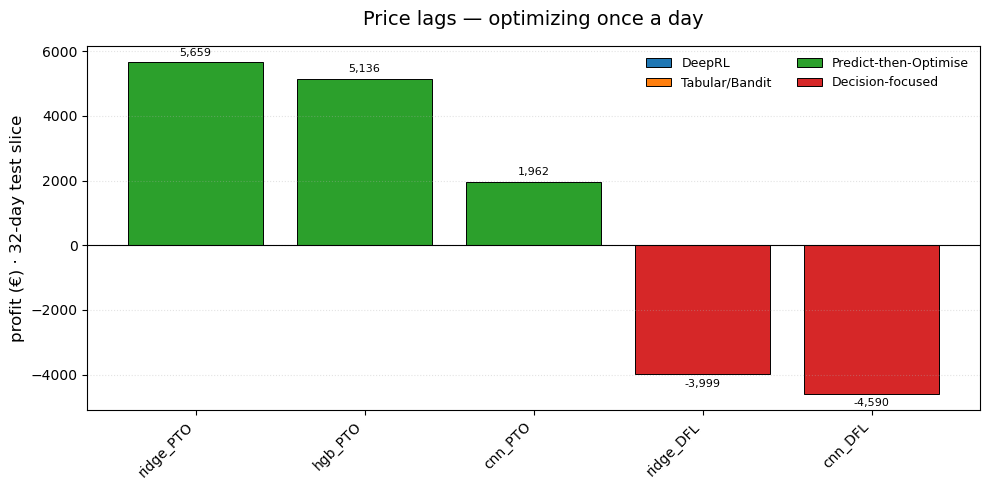

In [132]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Fancy bar chart – Base feature set (PC excluded)                    ║
# ╚══════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import numpy as np

# ── 1.  Filter & sort ---------------------------------------------------
base_no_pc = (profits_base
              .query("method != 'PC' and branch == 'B_day_ahead'")
              .sort_values("profit", ascending=False)
              .reset_index(drop=True))

# ── 2.  Colour-coding by family ----------------------------------------
family_map = {
    "DeepRL" : "tab:blue",
    "Tabular/Bandit" : "tab:orange",
    "Predict-then-Optimise" : "tab:green",
    "Decision-focused" : "tab:red",
}

def which_family(model_name: str) -> str:
    if model_name.startswith("DeepRL"):
        return "DeepRL"
    if model_name in ["LinUCB", "Q_table"]:
        return "Tabular/Bandit"
    if model_name.endswith("_PTO"):
        return "Predict-then-Optimise"
    return "Decision-focused"

bar_colors = [family_map[which_family(m)] for m in base_no_pc["model"]]

# ── 3.  Plot ------------------------------------------------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(base_no_pc["model"], base_no_pc["profit"],
               color=bar_colors, edgecolor="black", linewidth=.7)

# annotate each bar with its profit
for bar, val in zip(bars, base_no_pc["profit"]):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + (150 if val >= 0 else -150),
             f"{val:,.0f}",
             ha="center", va="bottom" if val >= 0 else "top",
             fontsize=8)

plt.axhline(0, color="black", linewidth=.8)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("profit (€) · 32-day test slice", fontsize=12)
plt.title("Price lags — optimizing once a day",
          fontsize=14, pad=15)
plt.grid(axis="y", linestyle=":", alpha=0.35)

# legend (one entry per family colour)
patches = [plt.Rectangle((0,0),1,1, color=col, ec="black", lw=.7)
           for col in family_map.values()]
plt.legend(patches, family_map.keys(),
           frameon=False, fontsize=9, ncol=2, loc="upper right")

plt.tight_layout()
#plt.savefig("fig1_base_fancy.png", dpi=150)
plt.show()


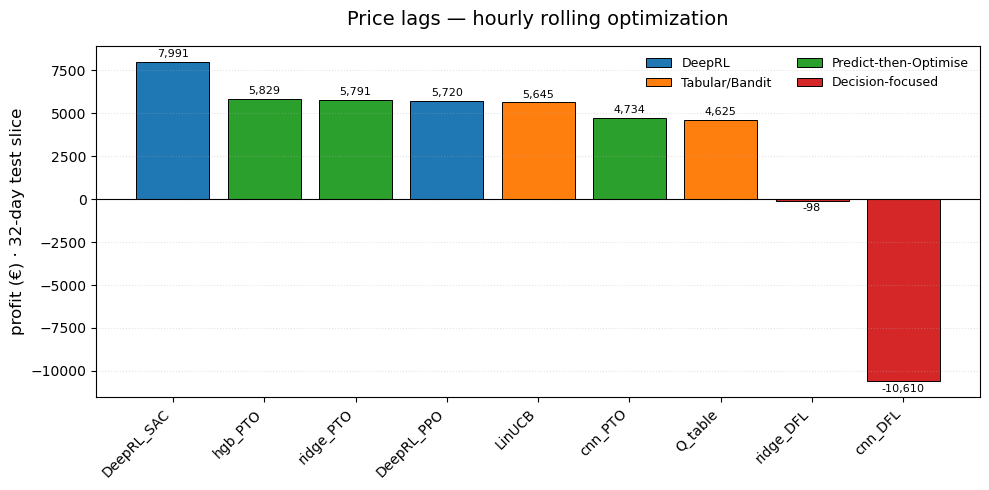

In [130]:
# ── 1.  Filter & sort ---------------------------------------------------
base_no_pc = (profits_base
              .query("method != 'PC' and branch == 'A_hourly'")
              .sort_values("profit", ascending=False)
              .reset_index(drop=True))

# ── 2.  Colour-coding by family ----------------------------------------
family_map = {
    "DeepRL" : "tab:blue",
    "Tabular/Bandit" : "tab:orange",
    "Predict-then-Optimise" : "tab:green",
    "Decision-focused" : "tab:red",
}

def which_family(model_name: str) -> str:
    if model_name.startswith("DeepRL"):
        return "DeepRL"
    if model_name in ["LinUCB", "Q_table"]:
        return "Tabular/Bandit"
    if model_name.endswith("_PTO"):
        return "Predict-then-Optimise"
    return "Decision-focused"

bar_colors = [family_map[which_family(m)] for m in base_no_pc["model"]]

# ── 3.  Plot ------------------------------------------------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(base_no_pc["model"], base_no_pc["profit"],
               color=bar_colors, edgecolor="black", linewidth=.7)

# annotate each bar with its profit
for bar, val in zip(bars, base_no_pc["profit"]):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + (150 if val >= 0 else -150),
             f"{val:,.0f}",
             ha="center", va="bottom" if val >= 0 else "top",
             fontsize=8)

plt.axhline(0, color="black", linewidth=.8)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("profit (€) · 32-day test slice", fontsize=12)
plt.title("Price lags — hourly rolling optimization",
          fontsize=14, pad=15)
plt.grid(axis="y", linestyle=":", alpha=0.35)

# legend (one entry per family colour)
patches = [plt.Rectangle((0,0),1,1, color=col, ec="black", lw=.7)
           for col in family_map.values()]
plt.legend(patches, family_map.keys(),
           frameon=False, fontsize=9, ncol=2, loc="upper right")

plt.tight_layout()
#plt.savefig("fig1_base_fancy.png", dpi=150)
plt.show()


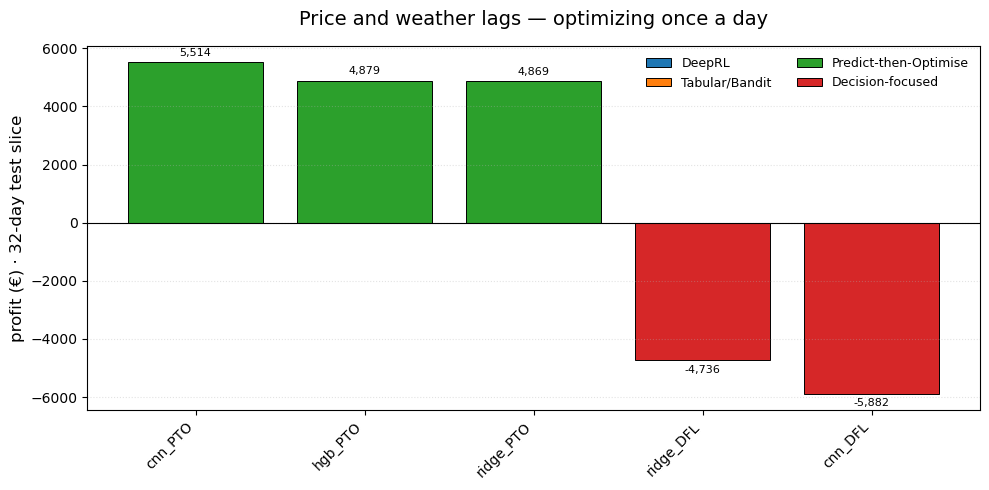

In [133]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Fancy bar chart – Base feature set (PC excluded)                    ║
# ╚══════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import numpy as np

# ── 1.  Filter & sort ---------------------------------------------------
base_no_pc = (profits_weather
              .query("method != 'PC' and branch == 'B_day_ahead'")
              .sort_values("profit", ascending=False)
              .reset_index(drop=True))

# ── 2.  Colour-coding by family ----------------------------------------
family_map = {
    "DeepRL" : "tab:blue",
    "Tabular/Bandit" : "tab:orange",
    "Predict-then-Optimise" : "tab:green",
    "Decision-focused" : "tab:red",
}

def which_family(model_name: str) -> str:
    if model_name.startswith("DeepRL"):
        return "DeepRL"
    if model_name in ["LinUCB", "Q_table"]:
        return "Tabular/Bandit"
    if model_name.endswith("_PTO"):
        return "Predict-then-Optimise"
    return "Decision-focused"

bar_colors = [family_map[which_family(m)] for m in base_no_pc["model"]]

# ── 3.  Plot ------------------------------------------------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(base_no_pc["model"], base_no_pc["profit"],
               color=bar_colors, edgecolor="black", linewidth=.7)

# annotate each bar with its profit
for bar, val in zip(bars, base_no_pc["profit"]):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + (150 if val >= 0 else -150),
             f"{val:,.0f}",
             ha="center", va="bottom" if val >= 0 else "top",
             fontsize=8)

plt.axhline(0, color="black", linewidth=.8)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("profit (€) · 32-day test slice", fontsize=12)
plt.title("Price and weather lags — optimizing once a day",
          fontsize=14, pad=15)
plt.grid(axis="y", linestyle=":", alpha=0.35)

# legend (one entry per family colour)
patches = [plt.Rectangle((0,0),1,1, color=col, ec="black", lw=.7)
           for col in family_map.values()]
plt.legend(patches, family_map.keys(),
           frameon=False, fontsize=9, ncol=2, loc="upper right")

plt.tight_layout()
#plt.savefig("fig1_base_fancy.png", dpi=150)
plt.show()


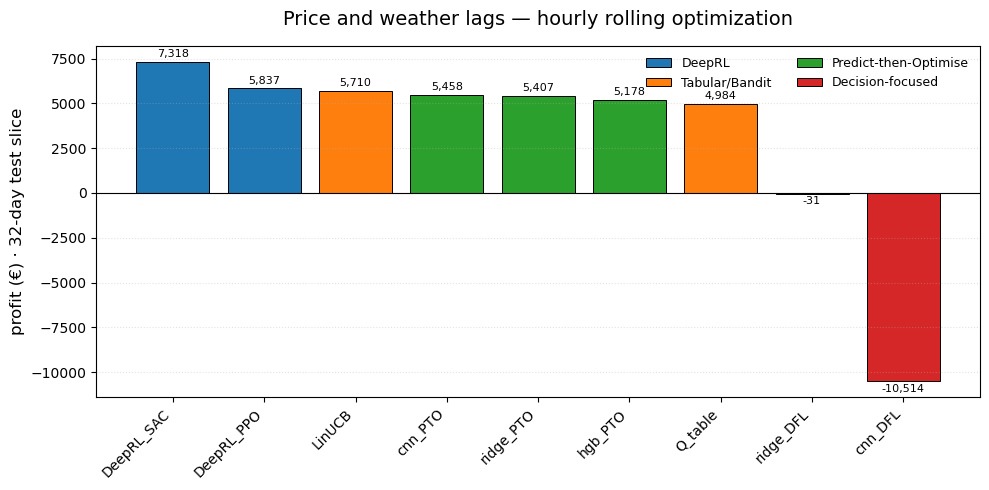

In [134]:
# ── 1.  Filter & sort ---------------------------------------------------
base_no_pc = (profits_weather
              .query("method != 'PC' and branch == 'A_hourly'")
              .sort_values("profit", ascending=False)
              .reset_index(drop=True))

# ── 2.  Colour-coding by family ----------------------------------------
family_map = {
    "DeepRL" : "tab:blue",
    "Tabular/Bandit" : "tab:orange",
    "Predict-then-Optimise" : "tab:green",
    "Decision-focused" : "tab:red",
}

def which_family(model_name: str) -> str:
    if model_name.startswith("DeepRL"):
        return "DeepRL"
    if model_name in ["LinUCB", "Q_table"]:
        return "Tabular/Bandit"
    if model_name.endswith("_PTO"):
        return "Predict-then-Optimise"
    return "Decision-focused"

bar_colors = [family_map[which_family(m)] for m in base_no_pc["model"]]

# ── 3.  Plot ------------------------------------------------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(base_no_pc["model"], base_no_pc["profit"],
               color=bar_colors, edgecolor="black", linewidth=.7)

# annotate each bar with its profit
for bar, val in zip(bars, base_no_pc["profit"]):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + (150 if val >= 0 else -150),
             f"{val:,.0f}",
             ha="center", va="bottom" if val >= 0 else "top",
             fontsize=8)

plt.axhline(0, color="black", linewidth=.8)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("profit (€) · 32-day test slice", fontsize=12)
plt.title("Price and weather lags — hourly rolling optimization",
          fontsize=14, pad=15)
plt.grid(axis="y", linestyle=":", alpha=0.35)

# legend (one entry per family colour)
patches = [plt.Rectangle((0,0),1,1, color=col, ec="black", lw=.7)
           for col in family_map.values()]
plt.legend(patches, family_map.keys(),
           frameon=False, fontsize=9, ncol=2, loc="upper right")

plt.tight_layout()
#plt.savefig("fig1_base_fancy.png", dpi=150)
plt.show()


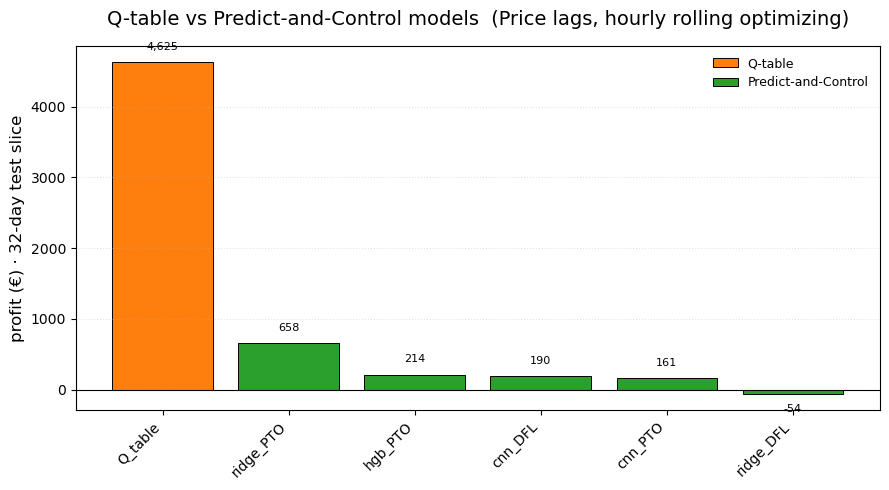

In [137]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  Bar chart · Q-table vs all Predict-and-Control models               ║
# ║            Base feature set · Hourly horizon                         ║
# ╚══════════════════════════════════════════════════════════════════════╝
#
# Shows one bar for the Q-table baseline and one bar for every PC model.
# Sorted high → low, € labels, colour-coded (Q-table orange, PC green).
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# ── 1 · gather the rows we need ----------------------------------------
pc_rows = profits_base.query("method == 'PC' and branch == 'A_hourly'") \
                      [["model", "profit"]]

q_row   = profits_base.query("model == 'Q_table' and branch == 'A_hourly'") \
                      [["model", "profit"]]

data = (pd.concat([q_row, pc_rows], ignore_index=True)
          .sort_values("profit", ascending=False)
          .reset_index(drop=True))

# ── 2 · colour map: Q-table = orange, PC = green -----------------------
colors = ["tab:orange" if m == "Q_table" else "tab:green"
          for m in data["model"]]

# ── 3 · plot ------------------------------------------------------------
plt.figure(figsize=(9, 5))
bars = plt.bar(data["model"], data["profit"],
               color=colors, edgecolor="black", linewidth=.7)

# annotate bars
for bar, val in zip(bars, data["profit"]):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + (150 if val >= 0 else -150),
             f"{val:,.0f}",
             ha="center", va="bottom" if val >= 0 else "top",
             fontsize=8)

plt.axhline(0, color="black", linewidth=.8)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("profit (€) · 32-day test slice", fontsize=12)
plt.title("Q-table vs Predict-and-Control models  (Price lags, hourly rolling optimizing)",
          fontsize=14, pad=15)
plt.grid(axis="y", linestyle=":", alpha=0.35)

# legend
handles = [plt.Rectangle((0,0),1,1,color="tab:orange", ec="black", lw=.7),
           plt.Rectangle((0,0),1,1,color="tab:green",  ec="black", lw=.7)]
plt.legend(handles, ["Q-table", "Predict-and-Control"],
           frameon=False, fontsize=9)

plt.tight_layout()
#plt.savefig("fig_q_vs_pc_base.png", dpi=150)
plt.show()


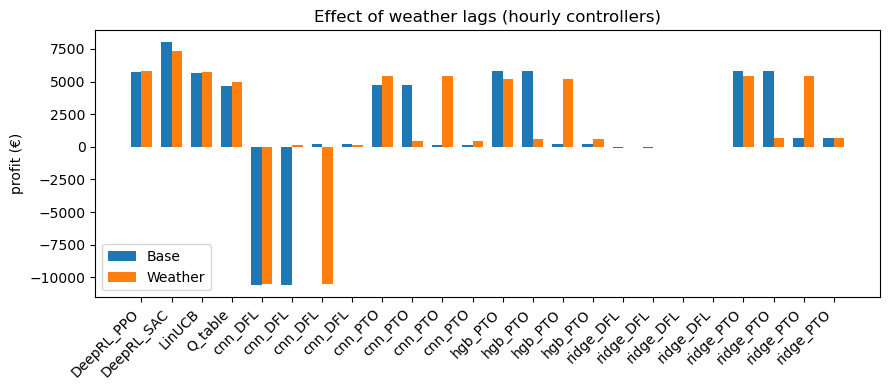

In [124]:
# ------------------------------------------------------------
# 3.  Side-by-side bars  (Base vs Weather)
# ------------------------------------------------------------
merged = (base_headline[["model","profit"]]
            .rename(columns={"profit":"profit_base"})
            .merge(weather_headline[["model","profit"]]
                   .rename(columns={"profit":"profit_weather"}),
                   on="model"))
x = range(len(merged))
w = 0.35
plt.figure(figsize=(9,4))
plt.bar([i-w/2 for i in x], merged["profit_base"],  width=w, label="Base")
plt.bar([i+w/2 for i in x], merged["profit_weather"], width=w, label="Weather")
plt.xticks(x, merged["model"], rotation=45, ha="right")
plt.ylabel("profit (€)")
plt.title("Effect of weather lags (hourly controllers)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_base_vs_weather.png", dpi=150)
plt.show()